# Install Libraries & Dependencies

In [1]:
pip install scikit-image

In [2]:
!pip install scikit-image --upgrade


In [3]:
import os
import numpy as np
import cv2
import glob
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras import layers, models

# Data Preprocessing

In [4]:
import zipfile
from pathlib import Path

# full path avoids ambiguity
zip_path = Path('/content/BraTs18.zip')  # change to your real location

if not zip_path.exists():
    raise FileNotFoundError(f"{zip_path} does not exist. "
                            "Check the path or upload the file.")

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall('/content')

In [5]:
images_dir = "/content/brats18/images"
masks_dir = "/content/brats18/masks"

image_files = sorted(glob.glob(os.path.join(images_dir, "image_*.png")))
print(f"Found {len(image_files)} image files: {image_files}")

mask_files = sorted(glob.glob(os.path.join(masks_dir, "mask_*.png")))
print(f"Found {len(mask_files)} mask files: {mask_files}")

Found 5042 image files: ['/content/brats18/images/image_1.png', '/content/brats18/images/image_10.png', '/content/brats18/images/image_100.png', '/content/brats18/images/image_1000.png', '/content/brats18/images/image_1001.png', '/content/brats18/images/image_1002.png', '/content/brats18/images/image_1003.png', '/content/brats18/images/image_1004.png', '/content/brats18/images/image_1005.png', '/content/brats18/images/image_1006.png', '/content/brats18/images/image_1007.png', '/content/brats18/images/image_1008.png', '/content/brats18/images/image_1009.png', '/content/brats18/images/image_101.png', '/content/brats18/images/image_1010.png', '/content/brats18/images/image_1011.png', '/content/brats18/images/image_1012.png', '/content/brats18/images/image_1013.png', '/content/brats18/images/image_1014.png', '/content/brats18/images/image_1015.png', '/content/brats18/images/image_1016.png', '/content/brats18/images/image_1017.png', '/content/brats18/images/image_1018.png', '/content/brats1

In [6]:
assert len(image_files) == len(mask_files), "Mismatch between images and masks!"

In [7]:
# Function to load an image as grayscale
def load_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return image

In [8]:
# Function to normalize an image by scaling pixel values to the range [0, 1]
def normalize_image(image):
    image = image.astype(np.float32)
    return image / 255.0

In [9]:
# Function to apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply((image * 255).astype(np.uint8)) / 255.0

In [10]:
# Function to resize an image to the target size (default 112x112)
def resize_image(image, target_size=(112, 112)):
    return cv2.resize(image, target_size)

In [11]:
# Function to preprocess the image by normalizing, enhancing contrast, and resizing
def preprocess_image(file_path, target_size=(112, 112)):
    image = load_image(file_path)
    normalized_image = normalize_image(image)
    enhanced_image = enhance_contrast(normalized_image)
    resized_image = resize_image(enhanced_image, target_size)
    return resized_image

In [12]:
# Shuffle and split the data into training and validation sets (80%/20%)
combined = list(zip(image_files, mask_files))
random.shuffle(combined)
split_idx = int(len(combined) * 0.8)
train_pairs = combined[:split_idx]
val_pairs = combined[split_idx:]

In [13]:
# Apply preprocessing to training and validation images
train_images = [preprocess_image(img_path) for img_path, _ in train_pairs]
train_masks = [load_image(mask_path) for _, mask_path in train_pairs]
val_images = [preprocess_image(img_path) for img_path, _ in val_pairs]
val_masks = [load_image(mask_path) for _, mask_path in val_pairs]

In [23]:
images = np.array([preprocess_image(f) for f in image_files])
masks  = np.array([load_image(f) for f in mask_files])
images = images[..., np.newaxis]

In [14]:
print(f"Sample preprocessed image shape: {train_images[0].shape}")
print(f"Sample mask shape: {train_masks[0].shape}")

Sample preprocessed image shape: (112, 112)
Sample mask shape: (240, 240)


# Exploratory Data Analysis (EDA)

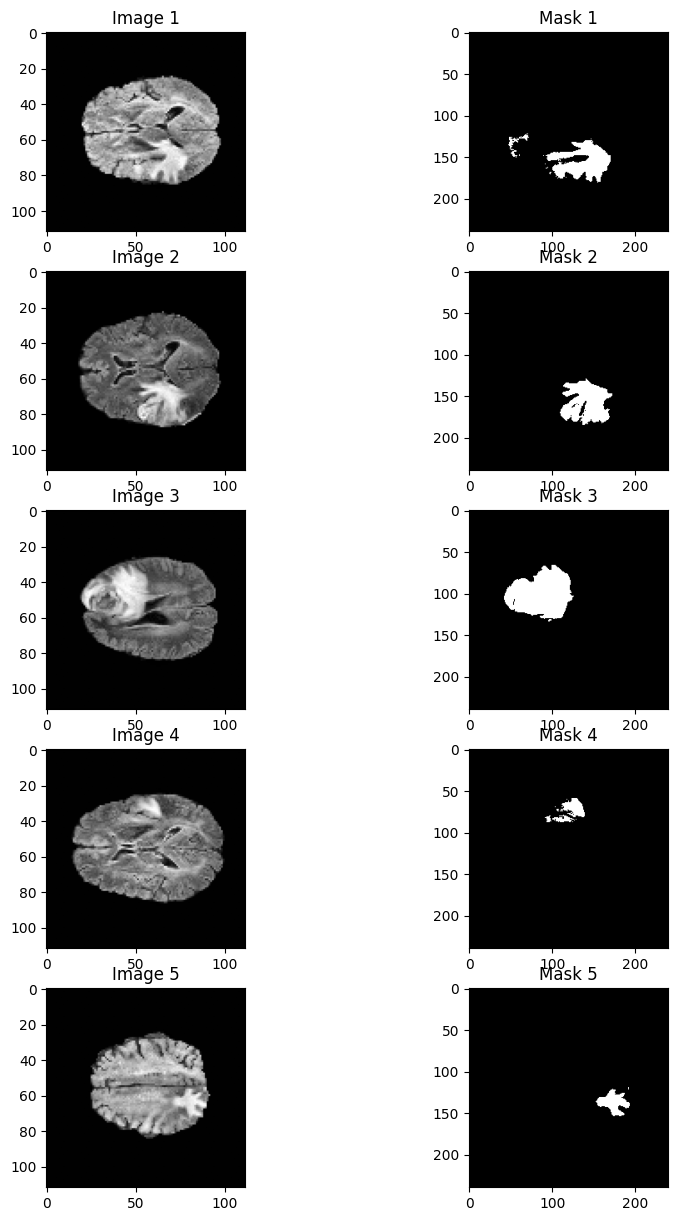

In [15]:
# Function to display sample images and their corresponding masks
def display_sample_images(images, masks, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 15))
    for i in range(n_samples):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
    plt.show()

display_sample_images(train_images, train_masks)

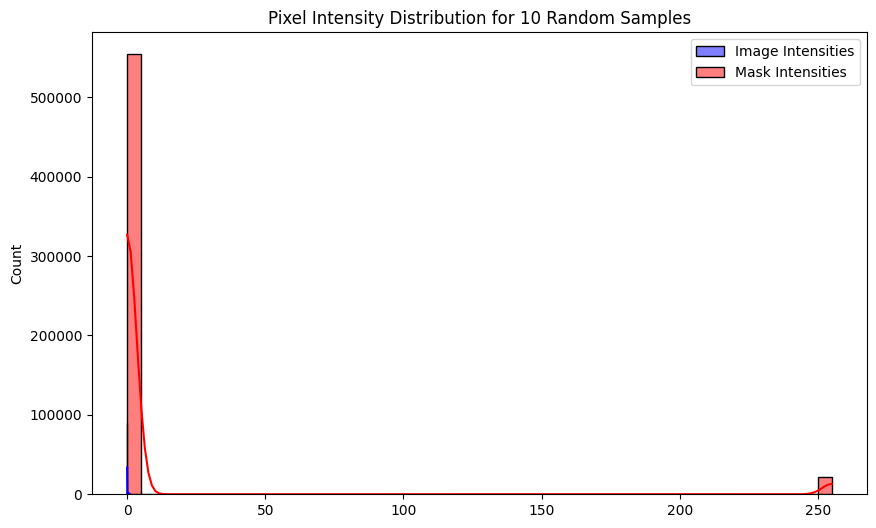

In [16]:
# Function to plot pixel intensity distribution for a small sample of images and masks
import random
def plot_pixel_intensity_histogram(images, masks, sample_size=10):
    sample_indices = random.sample(range(len(images)), sample_size)
    sample_images = [images[i] for i in sample_indices]
    sample_masks = [masks[i] for i in sample_indices]
    image_intensity = np.concatenate([img.flatten() for img in sample_images])
    mask_intensity = np.concatenate([mask.flatten() for mask in sample_masks])
    plt.figure(figsize=(10, 6))
    sns.histplot(image_intensity, bins=50, color='blue', label='Image Intensities', kde=True)
    sns.histplot(mask_intensity, bins=50, color='red', label='Mask Intensities', kde=True)
    plt.legend()
    plt.title(f'Pixel Intensity Distribution for {sample_size} Random Samples')
    plt.show()

plot_pixel_intensity_histogram(train_images, train_masks, sample_size=10)


# Feature Engineering

In [17]:
# Function to extract texture features using Grey Level Co-occurrence Matrix (GLCM)
def extract_texture_features(image):
    image = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    correlation = graycoprops(glcm, 'correlation')
    energy = graycoprops(glcm, 'energy')
    homogeneity = graycoprops(glcm, 'homogeneity')
    return contrast[0, 0], correlation[0, 0], energy[0, 0], homogeneity[0, 0]

features = extract_texture_features(train_images[0])
print("Texture Features (Contrast, Correlation, Energy, Homogeneity):", features)

Texture Features (Contrast, Correlation, Energy, Homogeneity): (np.float64(431.38963963963965), np.float64(0.9593762961321098), np.float64(0.6847806842514513), np.float64(0.7035740207016755))


# HGG & LGG

In [30]:
def create_dataset(images, masks, batch_size=128, patch_size=33):
    """
    Extract random 33×33 patches; label is the center‐pixel class.
    Filters out patches with labels outside the valid range.
    """
    patches, labels = [], []
    H, W = images.shape[1:3]
    half = patch_size // 2
    for img, m in zip(images, masks):
        for _ in range(50):
            y = random.randint(0, H - patch_size)
            x = random.randint(0, W - patch_size)
            patch = img[y:y+patch_size, x:x+patch_size, :]
            label = m[y+half, x+half]
            # Check if the label is within the valid range
            if 0 <= label < 5:  # Assuming 5 classes (0-4)
                patches.append(patch)
                labels.append(label)
    patches = np.array(patches, dtype=np.float32)
    labels  = np.array(labels,  dtype=np.int32)
    ds = tf.data.Dataset.from_tensor_slices((patches, labels))
    return ds.shuffle(1000).batch(batch_size)

In [31]:
def build_hgg_cnn(input_shape=(33,33,1), num_classes=5):
    inp = layers.Input(shape=input_shape)
    x = inp
    # Layers 1–3: 3×3 conv, 64 filters
    for _ in range(3):
        x = layers.Conv2D(64,3,padding='same',
                          kernel_initializer=initializers.GlorotUniform(),
                          bias_initializer=initializers.Constant(0.1))(x)
        x = layers.LeakyReLU(alpha=0.333)(x)
    # Pooling 3×3, stride 2
    x = layers.MaxPooling2D(3,2,padding='same')(x)
    # Layers 5–7: 3×3 conv, 128 filters
    for _ in range(3):
        x = layers.Conv2D(128,3,padding='same',
                          kernel_initializer=initializers.GlorotUniform(),
                          bias_initializer=initializers.Constant(0.1))(x)
        x = layers.LeakyReLU(alpha=0.333)(x)
    x = layers.MaxPooling2D(3,2,padding='same')(x)
    # FC Layers
    x = layers.Flatten()(x)
    x = layers.Dense(256,
                     kernel_initializer=initializers.GlorotUniform(),
                     bias_initializer=initializers.Constant(0.1))(x)
    x = layers.LeakyReLU(alpha=0.333)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256,
                     kernel_initializer=initializers.GlorotUniform(),
                     bias_initializer=initializers.Constant(0.1))(x)
    x = layers.LeakyReLU(alpha=0.333)(x)
    x = layers.Dropout(0.1)(x)
    out = layers.Dense(num_classes, activation='softmax',
                       kernel_initializer=initializers.GlorotUniform(),
                       bias_initializer=initializers.Constant(0.1))(x)
    return models.Model(inp, out, name='HGG_CNN')

In [32]:
def build_lgg_cnn(input_shape=(33,33,1), num_classes=5):
    inp = layers.Input(shape=input_shape)
    x = inp
    # Layers 1–2: 64 filters
    for _ in range(2):
        x = layers.Conv2D(64,3,padding='same',
                          kernel_initializer=initializers.GlorotUniform(),
                          bias_initializer=initializers.Constant(0.1))(x)
        x = layers.LeakyReLU(alpha=0.333)(x)
    x = layers.MaxPooling2D(3,2,padding='same')(x)
    # Layers 4–5: 128 filters
    for _ in range(2):
        x = layers.Conv2D(128,3,padding='same',
                          kernel_initializer=initializers.GlorotUniform(),
                          bias_initializer=initializers.Constant(0.1))(x)
        x = layers.LeakyReLU(alpha=0.333)(x)
    x = layers.MaxPooling2D(3,2,padding='same')(x)
    # FC Layers with p=0.5
    x = layers.Flatten()(x)
    x = layers.Dense(256,
                     kernel_initializer=initializers.GlorotUniform(),
                     bias_initializer=initializers.Constant(0.1))(x)
    x = layers.LeakyReLU(alpha=0.333)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256,
                     kernel_initializer=initializers.GlorotUniform(),
                     bias_initializer=initializers.Constant(0.1))(x)
    x = layers.LeakyReLU(alpha=0.333)(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax',
                       kernel_initializer=initializers.GlorotUniform(),
                       bias_initializer=initializers.Constant(0.1))(x)
    return models.Model(inp, out, name='LGG_CNN')

In [33]:
def train_model(model, train_ds, val_ds,
                initial_lr, final_lr, epochs,
                steps_per_epoch=None, validation_steps=None):
    lr_schedule = optimizers.schedules.PolynomialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=epochs,
        end_learning_rate=final_lr,
        power=1.0)
    opt = optimizers.SGD(
        learning_rate=lr_schedule,
        momentum=0.9,
        nesterov=True)
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[tf.keras.callbacks.EarlyStopping(
                       patience=3,
                       restore_best_weights=True)]
    )
    return model

In [37]:
train_ds_hgg = create_dataset(images, masks, batch_size=34, patch_size=33)
val_ds_hgg   = create_dataset(images, masks, batch_size=34, patch_size=33)

In [38]:
from tensorflow.keras import layers, models, initializers, optimizers # Import optimizers


In [44]:
hgg_model = build_hgg_cnn()
hgg_model = train_model(
    hgg_model,
    train_ds_hgg,
    val_ds_hgg,
    initial_lr=0.003,
    final_lr=0.00003,
    epochs=20,
    steps_per_epoch=100,                         # ← actually use 100
    validation_steps=100                         # ← or compute: len(images)*50 // batch_size
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9485 - loss: 0.1294 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 1.0000 - loss: 7.6160e-11 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 1.0000 - loss: 2.6027e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 1.0000 - loss: 1.2191e-11 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [45]:
lgg_model = build_lgg_cnn()
lgg_model = train_model(
    lgg_model,
    train_ds_hgg,
    val_ds_hgg,
    initial_lr=0.003,
    final_lr=0.00003,
    epochs=25,
    steps_per_epoch=100,                         # ← actually use 100
    validation_steps=100
)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 830ms/step - accuracy: 0.9549 - loss: 0.1162 - val_accuracy: 1.0000 - val_loss: 2.5490e-08
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 1.0000 - loss: 7.6860e-06 - val_accuracy: 1.0000 - val_loss: 2.4964e-08
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 1.0000 - loss: 1.5405e-05 - val_accuracy: 1.0000 - val_loss: 2.5314e-08
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 814ms/step - accuracy: 1.0000 - loss: 7.2881e-06 - val_accuracy: 1.0000 - val_loss: 2.5314e-08
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 1.0000 - loss: 1.1372e-05 - val_accuracy: 1.0000 - val_loss: 2.5209e-08


In [46]:
loss, acc = hgg_model.evaluate(val_ds_hgg)
print(f"Validation patch loss: {loss:.4f}, accuracy: {acc:.4f}")

  93/7293 ━━━━━━━━━━━━━━━━━━━━ 37:34 313ms/step - accuracy: 1.0000 - loss: 0.0000e+00

KeyboardInterrupt: 

In [47]:
from sklearn.metrics import classification_report, confusion_matrix


In [48]:
y_true = np.concatenate([y.numpy() for _, y in val_ds_hgg], axis=0)
y_probs = hgg_model.predict(val_ds_hgg)
y_pred  = np.argmax(y_probs, axis=1)
class_names = ['Non-tumor','Necrosis','Edema','Non-enhancing','Enhancing']

 197/7293 ━━━━━━━━━━━━━━━━━━━━ 39:56 338ms/step

KeyboardInterrupt: 

In [ ]:
class_names = ['Non-tumor'] # Adjust if another class is the only one present

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [50]:
!pip install lime
from lime import lime_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fec23fd9f90763d5b44a4b0e2ce13a4b982f899bb3ec32d9e75c392a3bde6875
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Get a sample patch and label from the dataset (e.g., from the first batch)
for sample_batch, sample_label in train_ds_hgg.take(1):  # Take the first batch
    sample_patch = sample_batch
    break  # Exit the loop after getting one batch

# Now you can proceed with the rest of the code
explainer = lime_image.LimeImageExplainer()
def fn(imgs):
    # imgs: list of uint8 RGB patches. Convert to grayscale and scale
    batch = np.stack([cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)/255. for im in imgs], axis=0)[...,None]
    return hgg_model.predict(batch)

patch_uint8 = (sample_patch[0,...,0].numpy()*255).astype(np.uint8) # Convert to NumPy array first
patch_rgb = cv2.cvtColor(patch_uint8, cv2.COLOR_GRAY2RGB)
exp = explainer.explain_instance(
    patch_rgb, fn, top_labels=1, hide_color=0, num_samples=1000
)
label_id = sample_label.numpy()[0]
temp, mask = exp.get_image_and_mask(
    label_id, positive_only=True, num_features=5, hide_rest=False
)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(patch_uint8, cmap='gray'); plt.title('Original Patch'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(temp); plt.title('LIME Explanation'); plt.axis('off')
plt.tight_layout(); plt.show()

In [ ]:
# Replace DeepExplainer with the compute_integrated_gradients workaround if necessary.
def compute_integrated_gradients(model, image, baseline, class_idx, steps=50):
    try:
        with shap.explainers._deep.deep_tf.op_handlers.passthrough():
            image = tf.convert_to_tensor(image, dtype=tf.float32)
            baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
            # Disable eager execution within this context
            tf.config.run_functions_eagerly(False)
    except AttributeError:
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
        # Disable eager execution in this case as well
        tf.config.run_functions_eagerly(False)

    grads = []
    for i in range(steps + 1):
        alpha = i / steps
        inp = baseline + alpha * (image - baseline)
        with tf.GradientTape() as tape:
            tape.watch(inp)
            preds = model(inp)
            loss = preds[:, class_idx]  # Remove the [0] indexing to consider the whole batch
        grad = tape.gradient(loss, inp)
        grads.append(grad)
    avg_grads = tf.reduce_mean(tf.stack(grads), axis=0)
    integrated = (image - baseline) * avg_grads
    ig = tf.reduce_sum(tf.abs(integrated), axis=-1).numpy()  # shape (batch_size, 33,33)
    # Re-enable eager execution if necessary
    tf.config.run_functions_eagerly(True)
    return ig
plt.subplot(1,2,1)
plt.imshow(patch_uint8, cmap='gray'); plt.title('Original Patch'); plt.axis('off')
plt.subplot(1,2,2)

In [ ]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.backprop_modifier import DeepLift


for batch, labels in val_ds_hgg.unbatch().batch(1).take(1):
    sample_patch = batch      # shape (1, 33,33,1)
    sample_label = int(labels.numpy()[0])
    break
saliency = Saliency(
    model=hgg_model,
    model_modifier=ReplaceToLinear(),  # replace final softmax with linear
    clone=True                         # avoid modifying original model
)

score = CategoricalScore([sample_label])
dl_maps = saliency(
    score,
    sample_patch,
    smooth_samples=0,
    smooth_noise=0.0,
    backprop_modifier=DeepLift()
)
dl_map = dl_maps[0, ..., 0]
h, w = dl_map.shape
inch_per_px = 0.1

fig, ax = plt.subplots(
    1, 1,
    figsize=(w * inch_per_px, h * inch_per_px),
    dpi=100
)
ax.imshow(
    dl_map,
    interpolation='nearest',
    aspect='equal',
    cmap='viridis'
)
ax.set_title(f"DeepLIFT via tf‑keras‑vis for class {sample_label}")
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import matplotlib.pyplot as plt
import numpy as np
for batch, labels in val_ds_hgg.unbatch().batch(1).take(1):
    sample_patch = batch      # shape (1,33,33,1)
    sample_label = int(labels.numpy()[0])
    break
patch_uint8 = (sample_patch[0, ..., 0].numpy() * 255).astype(np.uint8)

gradcam = Gradcam(
    model=hgg_model,
    model_modifier=ReplaceToLinear(),
    clone=True
)
score = CategoricalScore([sample_label])
cam = gradcam(
    score,
    sample_patch,
    penultimate_layer=12
)
cam_map = cam[0]
h, w = patch_uint8.shape
inch_per_px = 0.1

fig, axes = plt.subplots(
    1, 2,
    figsize=(w * inch_per_px * 2, h * inch_per_px),
    dpi=100
)

axes[0].imshow(
    patch_uint8,
    interpolation='nearest',
    aspect='equal'
)
axes[0].set_title('Original Patch')
axes[0].axis('off')

axes[1].imshow(
    cam_map,
    interpolation='nearest',
    aspect='equal'
)
axes[1].set_title('Grad-CAM')
axes[1].axis('off')

plt.tight_layout()
plt.show()
